In [2]:
import tensorflow as tf
import numpy as np
import os, re, gc
from imageio import imread
from skimage import transform
from vgg19 import Vgg19
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
class Vgg19_nts(Vgg19):
    def __init__(self, content_image_path, style_img_path, image_size=224, 
                 ratio_content_to_style=1e-3, vgg19_npy_path="vgg19.npy"):
       
        self.vgg_19_npy_path = vgg19_npy_path
        
        self._image_size = image_size
        self.content_img = imread(content_image_path)
        self.content_img = transform.resize(self.content_img, [image_size, image_size])
        self.content_img = np.expand_dims(self.content_img, axis=0)
        
        self.style_img = imread(style_img_path)
        self.style_img = transform.resize(self.style_img, [image_size, image_size])
        self.style_img = np.expand_dims(self.style_img, axis=0)
        self._ratio_content_to_style = ratio_content_to_style
        self._content_act_list, self._style_act_list = self.get_content_and_style_activations()
          
    def get_content_loss(self, content, generated_act):
        return(0.5*tf.reduce_sum(tf.square(tf.subtract(content,generated_act))))
    
    def get_gram(self, content):
        content = tf.squeeze(content, axis=0)
        gram = tf.reshape(content, (content.shape[0].value*content.shape[1].value, content.shape[2].value))
        return(tf.matmul(tf.transpose(gram), gram))
    
    def get_style_El(self, content_gram, generated_gram, no_of_filters, filter_size):
        El = tf.reduce_sum(tf.square(tf.subtract(generated_gram, content_gram)))/(4*(no_of_filters**2)*(filter_size**2))
        return(El)
 
    def calculate_total_loss(self):
        loss_content = 0
        loss_style = 0
        for it in self._content_act_list:
            generated_act = self.graph.get_tensor_by_name("{0}/{0}:0".format(it["layer_name"]))
            content_act = tf.constant(it["content_act"])
            loss_content += it["w"] * self.get_content_loss(content_act, generated_act)
        
        for it in self._style_act_list:
            generated_act = self.graph.get_tensor_by_name("{0}/{0}:0".format(it["layer_name"]))
            content_act = tf.constant(it["style_act"])
            
            generated_gram = self.get_gram(generated_act)
            content_gram = self.get_gram(content_act)
           
            no_of_filters = content_act.shape[3].value
            filter_size = content_act.shape[1].value*content_act.shape[2].value

            loss_style += it["w"] * self.get_style_El(content_gram, generated_gram, no_of_filters, filter_size)
            
        return(self._ratio_content_to_style*loss_content + loss_style)
       
    def build_optmizer(self, learning_rate):
        loss = self.calculate_total_loss()
        optimizer = tf.train.AdamOptimizer(learning_rate)
        return([optimizer, optimizer.minimize(loss), loss])
    
    def get_content_and_style_activations(self):
   
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            with tf.device("/cpu:0"):
                imgs = tf.placeholder(shape=[1, self._image_size, self._image_size, 3], dtype=tf.float32)
                vgg19_ref = Vgg19(self.vgg_19_npy_path, image_size=self._image_size)
                vgg19_ref.build(imgs)
                self.graph = sess.graph

                style_acts = [{"layer_name":"conv1_1", "style_act":0, "w":1e3/64**2},
                          {"layer_name":"conv2_1", "style_act":0, "w":1e3/128**2},
                          {"layer_name":"conv3_1", "style_act":0, "w":1e3/256**2},
                          {"layer_name":"conv4_1", "style_act":0, "w":1e3/512**2},
                          {"layer_name":"conv5_1", "style_act":0, "w":1e3/512**2}]

                content_acts = [{"layer_name":"conv4_2", "content_act":0, "w":1}]

                for i, ls in enumerate(style_acts):
                    style_acts[i]["style_act"] = sess.run("{0}/{0}:0".format(ls["layer_name"]), 
                                                          feed_dict={imgs:self.style_img})
    

                for i, lc in enumerate(content_acts):
                    content_acts[i]["content_act"] = sess.run("{0}/{0}:0".format(lc["layer_name"]), 
                                                              feed_dict={imgs:self.content_img})
        del vgg19_ref
        gc.collect()
      
        return(content_acts, style_acts)
    
    def paint(self, learning_rate=0.005, no_of_epochs = 100, sample_rate=10, stack_len=10):
        tf.reset_default_graph()
        images = list()

        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
       
            with tf.device("/cpu:0"):
                imgs = tf.get_variable(shape=[1, self._image_size, self._image_size, 3], initializer=tf.random_uniform_initializer(0, 1), 
                                   name="painted", dtype=tf.float32) 
           
                Vgg19.__init__(self, vgg19_npy_path=self.vgg_19_npy_path,image_size=self._image_size)
                Vgg19.build(self, imgs)
                
                self.graph = sess.graph
                
                sess.run(tf.variables_initializer([imgs]))
 
                adam_op, op_min, loss = self.build_optmizer(learning_rate=learning_rate)
                adam_vars = [v for v in self.graph.get_collection("variables") 
                             if v.name in ['beta1_power:0', 'beta2_power:0', 'painted/Adam:0', 'painted/Adam_1:0']]
                sess.run(tf.variables_initializer(adam_vars))
        
                for epoch in range(no_of_epochs):
                    _, ls = sess.run([op_min, loss])
                    if epoch%sample_rate==0:
                        images.append(np.clip(sess.run(imgs), 0, 1))
                        if len(images)>stack_len:
                            images = images[-stack_len::]
                    print("\r loss:{:<8}  epoch:{} of {}".format(ls, epoch, no_of_epochs), end=" ")   
        return(images)

In [12]:
vv = Vgg19_nts(content_image_path="sh.jpg", style_img_path="the-red-vineyard.jpg", ratio_content_to_style=1e-2, 
               vgg19_npy_path="vgg19_from_h5.npy", )

images = vv.paint(no_of_epochs=400)

C:\Users\srajabza\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


npy file loaded
build model started
build model finished: 0s
npy file loaded
build model started
build model finished: 0s
 loss:20430580.0  epoch:276 of 400 

KeyboardInterrupt: 

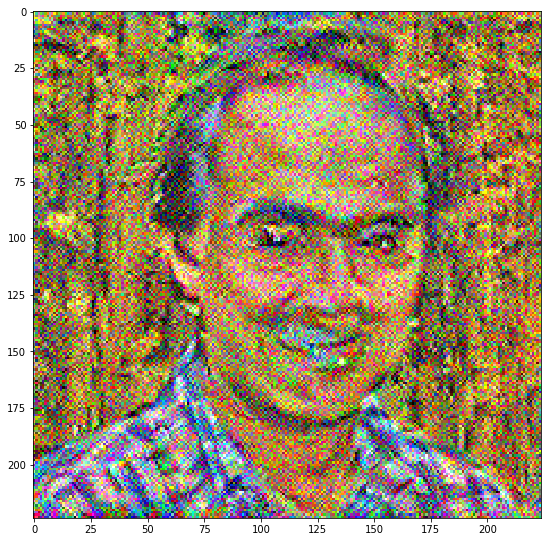

In [13]:
#Need to add the image net mean and clip for 0 to 1
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(images[-1].squeeze())